*Material adapted from: http://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/*

March, 2016

#XGBoost. KAGGLE COMPETITION: SANTANDER CUSTOMER SATISFACTION


##INDEX<a id='index'></a>

0.[ **INTRODUCTION**](#0)

0.1[ Notebook's main goal](#0.1)

0.2[ About the competition. Data used](#0.2)

0.3[ About XGBoost](#0.3)
    

1.[ **IMPORT DATA AND PACKAGES**](#1)


2.[ **MODEL: XGBOOST**](#2)

[Go to index](#index)

##0. INTRODUCTION <a id='0'></a>

###0.1 Notebook's main goal <a id='0.1'></a>

The goal of this notebook is to use XGBoost to predict customer satisfaction, in the context of Santander's Kaggle competition.

[Go to index](#index)

###0.2 About the competition. Data used <a id='0.2'></a>

https://www.kaggle.com/c/santander-customer-satisfaction


Downloaded data:
- `train.csv`
- `test.csv`

[Go to index](#index)

###0.3 About XGBoost <a id='0.3'></a>

Review:
- Complete Guide to Parameter Tuning in Gradient Boosting (GBM) in Python (http://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/)
- Complete Guide to Parameter Tuning in XGBoost (with codes in Python) (http://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/)


To install XGBoost in a Windows 8 laptop I followed these instructions (from Disco4ever answer at http://stackoverflow.com/questions/33749735/how-to-install-xgboost-package-in-python-windows-platform):

"Note that as of the most recent release the Microsoft Visual Studio instructions no longer seem to apply as this link returns a 404 error:

https://github.com/dmlc/xgboost/tree/master/windows

You can read more about the removal of the MSVC build from Tianqi Chen's comment here.

So here's what I did to finish a 64-bit build on Windows:

    Download and install MinGW-64: http://sourceforge.net/projects/mingw-w64/
    On the first screen of the install prompt make sure you set the Architecture to x86_64 and the Threads to win32
    I installed to C:\mingw64 (to avoid spaces in the file path) so I added this to my PATH environment variable: C:\mingw64\mingw64\bin
    I also noticed that the make utility that is included in bin\mingw64 is called mingw32-make so to simplify things I just renamed this to make
    Open a Windows command prompt and type gcc. You should see something like "fatal error: no input file"
    Next type make. You should see something like "No targets specified and no makefile found"
    Type git. If you don't have git, install it and add it to your PATH.

These should be all the tools you need to build the xgboost project. To get the source code run these lines:

    cd c:\
    git clone --recursive https://github.com/dmlc/xgboost
    cd xgboost
    git submodule init
    git submodule update
    cp make/mingw64.mk config.mk
    make -j4

Note that I ran this part from a Cygwin shell. If you are using the Windows command prompt you should be able to change cp to copy and arrive at the same result. However, if the build fails on you for any reason I would recommend trying again using cygwin.

If the build finishes successfully, you should have a file called xgboost.exe located in the project root. To install the Python package, do the following:

    cd python-package
    python setup.py install

Now you should be good to go. Open up Python, and you can import the package with:

import xgboost as xgb"


[Go to index](#index)

##1.  IMPORT PACKAGES AND DATA<a id='1'></a>

Let's import packages used in this notebook:

In [ ]:
#Import libraries:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

To import data, first we import the file "train.csv", that contains the data provided for this project. And "test.csv" used to evaluate model.

In [2]:
train = pd.read_csv('train.csv')
target = 'TARGET'
IDcol = 'ID'
test = pd.read_csv('test.csv')

Let's check types

In [4]:
#Let's check the data type
train.dtypes.value_counts()

int64      260
float64    111
dtype: int64

In [8]:
X_train = train[:]
del X_train["TARGET"]
print "Feature space holds %d observations and %d features" % X_train.shape

Feature space holds 76020 observations and 370 features


[Go to index](#index)

##2. MODEL: XGBOOST <a id='2'></a>

In this case study, we aim at building a machine learning model based on XGBoost for customer dissatisfaction prediction on data from a Banco Santander company. 

Data is available throught KAGGLE competition.

370 numeric features, 260 integers + 110 float.

In [11]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, verbose_eval=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % metrics.accuracy_score(dtrain[target].values, dtrain_predictions)
    print "AUC Score (Train): %f" % metrics.roc_auc_score(dtrain[target], dtrain_predprob)
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

##2.1TUNNING

### Step 1: Fix learning rate and number of estimators for tuning tree-based parameters

Optimum number of trees?

In [11]:
#Choose all predictors except target & IDcols
predictors = [x for x in train.columns if x not in [target, IDcol]]


Model Report
Accuracy : 0.9611
AUC Score (Train): 0.877768


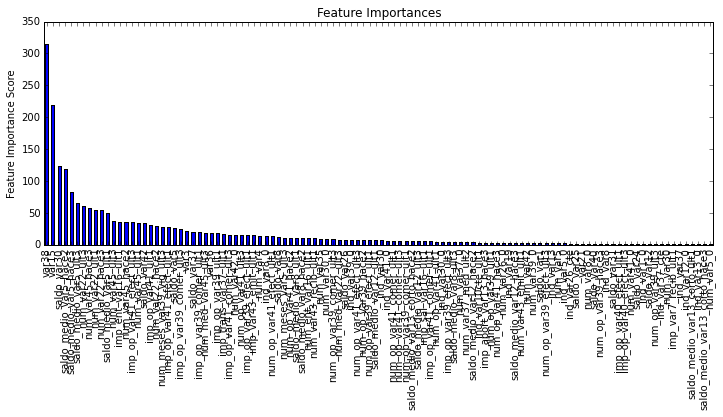

In [ ]:
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=110,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, train, predictors)

So... Let's see how many important features there are. We will store them in predictors2 variable

In [10]:
#Let's see how many important features there are:
predictors2 = pd.Series(xgb1.booster().get_fscore()).index
print len(predictors2)

110


##Step 2: Tune max_depth and min_child_weight

At this point:
- n_estimators = 110

In [ ]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=1000, max_depth=8, 
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.85,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch1.fit(train[predictors],train[target])

gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

Here, we get the optimum values of 3 for max_depth and 3 for min_child_weight. Next step: fine tuning.

In [17]:
param_test2 = {
 'max_depth':[2,3,4],
 'min_child_weight':[2,3,4]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=110, max_depth=8,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.85,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(train[predictors],train[target])
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.83662, std: 0.00790, params: {'max_depth': 2, 'min_child_weight': 2},
  mean: 0.83689, std: 0.00797, params: {'max_depth': 2, 'min_child_weight': 3},
  mean: 0.83693, std: 0.00802, params: {'max_depth': 2, 'min_child_weight': 4},
  mean: 0.83876, std: 0.00857, params: {'max_depth': 3, 'min_child_weight': 2},
  mean: 0.83891, std: 0.00892, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.83912, std: 0.00838, params: {'max_depth': 3, 'min_child_weight': 4},
  mean: 0.83893, std: 0.00943, params: {'max_depth': 4, 'min_child_weight': 2},
  mean: 0.83895, std: 0.00941, params: {'max_depth': 4, 'min_child_weight': 3},
  mean: 0.83891, std: 0.00946, params: {'max_depth': 4, 'min_child_weight': 4}],
 {'max_depth': 3, 'min_child_weight': 4},
 0.83911840541338167)

So, optimum values are max_depth = 3, min_child_weight=4.

##Step 3: Tune gamma

At this point:
- n_estimators = 110
- max_depth = 3
- min_child_weight=4

In [18]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=110, max_depth=3,
 min_child_weight=4, gamma=0, subsample=0.8, colsample_bytree=0.85,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(train[predictors],train[target])
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.83912, std: 0.00838, params: {'gamma': 0.0},
  mean: 0.83896, std: 0.00860, params: {'gamma': 0.1},
  mean: 0.83900, std: 0.00862, params: {'gamma': 0.2},
  mean: 0.83906, std: 0.00845, params: {'gamma': 0.3},
  mean: 0.83898, std: 0.00847, params: {'gamma': 0.4}],
 {'gamma': 0.0},
 0.83911840541338167)

So, optimum value is gamma=0.0


Model Report
Accuracy : 0.9606
AUC Score (Train): 0.855207


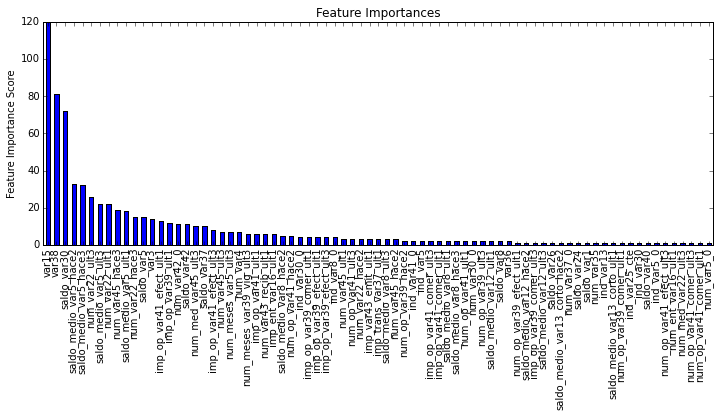

In [19]:
#re-calibrate the number of boosting rounds for the updated parameters

xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=110,
 max_depth=3,
 min_child_weight=4,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.85,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb2, train, predictors)

In [20]:
#Let's see how many important features there are:
predictors3 = pd.Series(xgb2.booster().get_fscore()).index
print len(predictors3)

77


##Step 4: Tune subsample and colsample_bytree

At this point, considering new n_estimators:
- n_estimators = 77
- max_depth = 3
- min_child_weight=4
- gamma = 0.0

In [21]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=77, max_depth=3,
 min_child_weight=4, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(train[predictors],train[target])
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: 0.83733, std: 0.00914, params: {'subsample': 0.6, 'colsample_bytree': 0.6},
  mean: 0.83835, std: 0.00877, params: {'subsample': 0.7, 'colsample_bytree': 0.6},
  mean: 0.83808, std: 0.00909, params: {'subsample': 0.8, 'colsample_bytree': 0.6},
  mean: 0.83776, std: 0.00914, params: {'subsample': 0.9, 'colsample_bytree': 0.6},
  mean: 0.83833, std: 0.00889, params: {'subsample': 0.6, 'colsample_bytree': 0.7},
  mean: 0.83816, std: 0.00904, params: {'subsample': 0.7, 'colsample_bytree': 0.7},
  mean: 0.83848, std: 0.00931, params: {'subsample': 0.8, 'colsample_bytree': 0.7},
  mean: 0.83731, std: 0.00906, params: {'subsample': 0.9, 'colsample_bytree': 0.7},
  mean: 0.83833, std: 0.00941, params: {'subsample': 0.6, 'colsample_bytree': 0.8},
  mean: 0.83813, std: 0.00930, params: {'subsample': 0.7, 'colsample_bytree': 0.8},
  mean: 0.83789, std: 0.00916, params: {'subsample': 0.8, 'colsample_bytree': 0.8},
  mean: 0.83757, std: 0.00918, params: {'subsample': 0.9, 'colsample_bytree'

Optimal values are subsample= 0.8, colsample_bytree=0.7

Next step: finetuning around values (try values in 0.05 interval around these)

In [27]:
param_test5 = {
 'subsample':[i/100.0 for i in range(75,90,5)],
 'colsample_bytree':[i/100.0 for i in range(65,80,5)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=77, max_depth=3,
 min_child_weight=4, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(train[predictors],train[target])
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

([mean: 0.83812, std: 0.00890, params: {'subsample': 0.75, 'colsample_bytree': 0.65},
  mean: 0.83844, std: 0.00924, params: {'subsample': 0.8, 'colsample_bytree': 0.65},
  mean: 0.83801, std: 0.00856, params: {'subsample': 0.85, 'colsample_bytree': 0.65},
  mean: 0.83827, std: 0.00870, params: {'subsample': 0.75, 'colsample_bytree': 0.7},
  mean: 0.83848, std: 0.00931, params: {'subsample': 0.8, 'colsample_bytree': 0.7},
  mean: 0.83834, std: 0.00868, params: {'subsample': 0.85, 'colsample_bytree': 0.7},
  mean: 0.83825, std: 0.00894, params: {'subsample': 0.75, 'colsample_bytree': 0.75},
  mean: 0.83793, std: 0.00925, params: {'subsample': 0.8, 'colsample_bytree': 0.75},
  mean: 0.83775, std: 0.00964, params: {'subsample': 0.85, 'colsample_bytree': 0.75}],
 {'colsample_bytree': 0.7, 'subsample': 0.8},
 0.83848072745778024)

So, optimum values are subsample=0.85, colsample_bytree=0.75

##Step 5: Tuning Regularization Parameters

At this point, considering new n_estimators:
- n_estimators = 77
- max_depth = 3
- min_child_weight=4
- gamma = 0.0
- subsample=0.85
- colsample_bytree=0.75


In [29]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=77, max_depth=3,
 min_child_weight=4, gamma=0.0, subsample=0.85, colsample_bytree=0.75,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6.fit(train[predictors],train[target])
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

([mean: 0.83775, std: 0.00964, params: {'reg_alpha': 1e-05},
  mean: 0.83778, std: 0.00967, params: {'reg_alpha': 0.01},
  mean: 0.83818, std: 0.00902, params: {'reg_alpha': 0.1},
  mean: 0.83795, std: 0.00905, params: {'reg_alpha': 1},
  mean: 0.82815, std: 0.00895, params: {'reg_alpha': 100}],
 {'reg_alpha': 0.1},
 0.83817717972339045)

In [30]:
param_test7 = {
 'reg_alpha':[0.008, 0.009, 0.01, 0.011, 0.012]
}
gsearch7 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=77, max_depth=3,
 min_child_weight=4, gamma=0.0, subsample=0.85, colsample_bytree=0.75,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test7, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch7.fit(train[predictors],train[target])
gsearch7.grid_scores_, gsearch7.best_params_, gsearch7.best_score_

([mean: 0.83778, std: 0.00967, params: {'reg_alpha': 0.008},
  mean: 0.83778, std: 0.00967, params: {'reg_alpha': 0.009},
  mean: 0.83778, std: 0.00967, params: {'reg_alpha': 0.01},
  mean: 0.83771, std: 0.00955, params: {'reg_alpha': 0.011},
  mean: 0.83771, std: 0.00955, params: {'reg_alpha': 0.012}],
 {'reg_alpha': 0.008},
 0.83778496638965971)

In [32]:
param_test7 = {
 'reg_alpha':[0.005, 0.006, 0.007]
}
gsearch7 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=77, max_depth=3,
 min_child_weight=4, gamma=0.0, subsample=0.85, colsample_bytree=0.75,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test7, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch7.fit(train[predictors],train[target])
gsearch7.grid_scores_, gsearch7.best_params_, gsearch7.best_score_

([mean: 0.83779, std: 0.00967, params: {'reg_alpha': 0.005},
  mean: 0.83779, std: 0.00967, params: {'reg_alpha': 0.006},
  mean: 0.83779, std: 0.00967, params: {'reg_alpha': 0.007}],
 {'reg_alpha': 0.005},
 0.8377859220841628)

Optimal value for reg_alpha=0.006


Model Report
Accuracy : 0.9607
AUC Score (Train): 0.858374


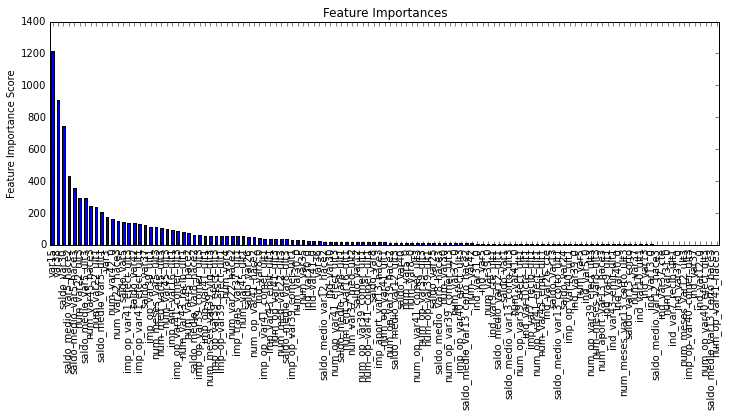

In [33]:
xgb3 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=5000,
 max_depth=3,
 min_child_weight=4,
 gamma=0,
 subsample=0.85,
 colsample_bytree=0.75,
 reg_alpha=0.006,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb3, train, predictors)

##2.2 PREDICT

#### ENTRY 11 - BEST SCORE - USING BOOSTER=GBTREE


https://github.com/dmlc/xgboost/blob/master/demo/guide-python/basic_walkthrough.py

In [44]:
##new try
dtrain = xgb.DMatrix(data=train[predictors], label=train[target])
dtest = xgb.DMatrix(test[predictors])


# specify parameters via map, definition are same as c++ version
paramxgb4 = {
    'booster':'gbtree',
    'silent':1,
    'nthread':4,
    'eta':0.01,
    'gamma':0.0,
    'max_depth':3,
    'min_child_weight':4,
    'subsample':0.85,
    'colsample_bytree':0.75,
    'alpha':0.006,
    'objective':'binary:logistic',
    'eval_metric':'auc',
    'seed':27
}

# specify validations set to watch performance
watchlist  = [(dtrain,'train')]
num_round = 1000
bst = xgb.train(paramxgb4, dtrain, num_round, watchlist)

# save model
bst.save_model('xgb4.model')




In [43]:
# this is prediction
y_pred = bst.predict(dtest)

# Output to csv
filename = 'submission11.csv'
pd.DataFrame({'ID': test[IDcol], 'TARGET': y_pred}).to_csv(filename, index=False)

#THIS SUBMISSION (11) SCORED 0.837348